# D. Modeling

# Load Packages

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_precision_recall_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
import datetime
import numpy as np
import pickle
import xgboost as xgb
from numpy import argmax
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 

# Load Data

In [2]:
# Specifiy filepath
filepath = '../data/interim/'

In [3]:
# Load feature and target data
X = pickle.load(open(filepath + 'X.pkl', 'rb'))
y = pickle.load(open(filepath + 'y.pkl', 'rb'))
feature_names = pickle.load(open(filepath + 'feature_names_base.pkl', 'rb'))
features_coded = pickle.load(open(filepath + 'features_coded_base.pkl', 'rb'))
X_train = pickle.load(open(filepath + 'X_train_base.pkl', 'rb'))
y_train = pickle.load(open(filepath + 'y_train_base.pkl', 'rb'))
X_test = pickle.load(open(filepath + 'X_test_base.pkl', 'rb'))
y_test = pickle.load(open(filepath + 'y_test_base.pkl', 'rb'))
logreg = pickle.load(open(filepath + 'logreg_base.pkl', 'rb'))

# Baseline Peformance From Logistic Regression Model

We computed various performance metrics for our baseline logistic regression model in the pre-processing notebook. The key metric for our classification task was determined to be the area under the precision-recall curve (also known as average precision) because our focus is on optimizing the proper classification of our minority class (e.g. those who said 'yes' to the marketing request). The ratio between our minority (1) and majority class (0) was determined to be 1:7.88 or approximately 0.12. This corresponds to the area under the precision-recall curve for perfect recall. It is the odds of randomly chosing an example from the minority class in the dataset. Any model we choose must beat this benchmark of 0.12 (or its representative value given the distribution of minority and majority classes in the dataset). Our logistic regression model yielded an average precision of 0.46. We will review a random forest and XGBoost algorithm to determine if we can improve on this score. We will also trial techniques such as applying class weights and resampling the data to determine if our score improves.

# Peformance Assessment Function

The function below will be used to compute a variety of performance metrics on a 10-fold cross validation set (done on the test set) and the test set. Of paramountcy are the computed values for average precision. Other revealing metrics include the precision, recall and F1 scores for a probability threshold of 50%. 

In [4]:
# Mean Average Precision on cross-validation set
def model_performance(clf, feature = X_train, target = y_train, kfolds = 10):
    '''This function computes the average precision score for a 10-fold cross validation set, average precision on the test set
    and a precision-recall plot for the test set'''
    #Cross validation scores on training set
    print(f'\033[4mResults for {clf.__name__} \033[0m')
    cv_results = cross_validate(estimator = clf, X = feature, y = target,  \
                                           scoring = 'average_precision', cv= kfolds)
    cv_scores = cv_results['test_score']
    print(f"Area Under Precision-Recall Curve for Train Set ({kfolds}-fold CV): {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}")
    
    #Performance on test set
    clf.fit(feature, target)
    y_clf_pred = clf.predict(X_test)
    y_clf_prob = clf.predict_proba(X_test)[:,1]
    
    
    #Area under precision-recall curve is equivalent to the average precision
    auc_pr = average_precision_score(y_test, y_clf_prob)
    print(f'Area Under Precision-Recall Curve for Test Set              : {auc_pr:.2f}')
    
    #Baseline performance
    no_skill = len(y_test[y_test==1]) / len(y_test)
    print(f'Area Under P-R Curve on Test Set (No-Skill Performance)     : {no_skill:.2f}')
    
    print(classification_report(y_test, y_clf_pred))
    

    #Plot precision-recall curve and show no-skill line
    precision, recall, thresholds = precision_recall_curve(y_test, y_clf_prob) 
    plt.figure(figsize = (10, 5))
    plt.title(f'Precision versus Recall of {clf.__name__}')
    plt.plot(recall, precision, marker = '.', label = f'{clf.__name__}', zorder = -1)
    plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.annotate(f'(0.00, {no_skill: .2f})',(0, no_skill))

    plt.legend()
    plt.show()
    
    


    

# Baseline Performance of Algorithms

## Logistic Regression

We already determined the baseline performance for the logistic regression algorithm. However, we will review the associated precision-recall curve. 

In [5]:
logreg.__name__ = 'Logistic Regression'

Results for Logistic Regression 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.45 +/- 0.02
Area Under Precision-Recall Curve for Test Set              : 0.46
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     10965
           1       0.67      0.25      0.37      1392

    accuracy                           0.90     12357
   macro avg       0.79      0.62      0.66     12357
weighted avg       0.89      0.90      0.88     12357



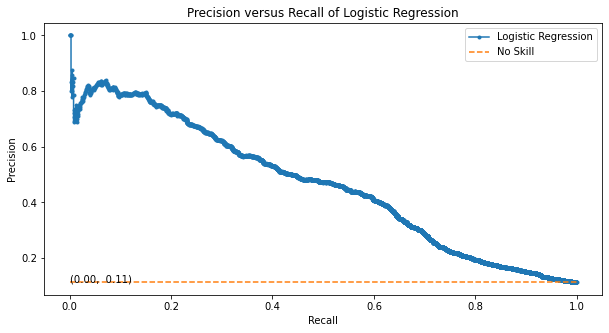

In [6]:
model_performance(logreg, kfolds = 10)

The cross validation AUC-PR score of 0.45 is close to the test set score of 0.46. There is therefore minimal overfitting in the model. This test performance is also better than the no-skill performance of 0.11, however the recall on the minority class of 0.25 is low. 

## Random Forest

Let us assess the performance of the baseline random forest model. 

In [7]:
rf = RandomForestClassifier(random_state = 77)
rf.__name__ = 'Random Forest'

Results for Random Forest 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.40 +/- 0.03
Area Under Precision-Recall Curve for Test Set              : 0.42
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     10965
           1       0.57      0.32      0.41      1392

    accuracy                           0.90     12357
   macro avg       0.74      0.64      0.68     12357
weighted avg       0.88      0.90      0.88     12357



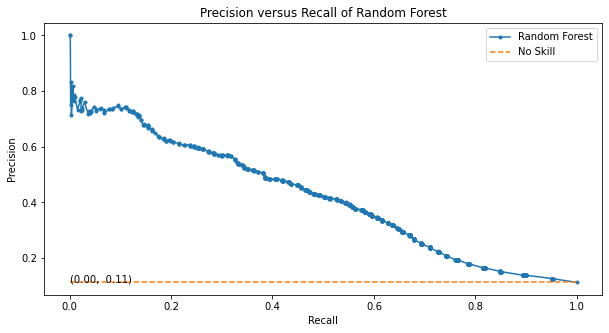

In [8]:
model_performance(rf, kfolds = 10)

The closeness of the cross validation score for the training set and the score for the test set suggest that there is minimal overfitting. The cross performance of 0.4 is worse than that observed from the logistic regression algorithm (0.44), suggesting that the logistic regression model performs better than random forest. However, the random forest offers better test scores on precision than the logistic regression model.  

## XGBoost Classifier

In [9]:
xg_cl = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder = False, eval_metric = 'logloss', seed= 77)
xg_cl.__name__ = 'XGBoost'

Results for XGBoost 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.44 +/- 0.03
Area Under Precision-Recall Curve for Test Set              : 0.46
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     10965
           1       0.60      0.31      0.41      1392

    accuracy                           0.90     12357
   macro avg       0.76      0.64      0.68     12357
weighted avg       0.88      0.90      0.88     12357



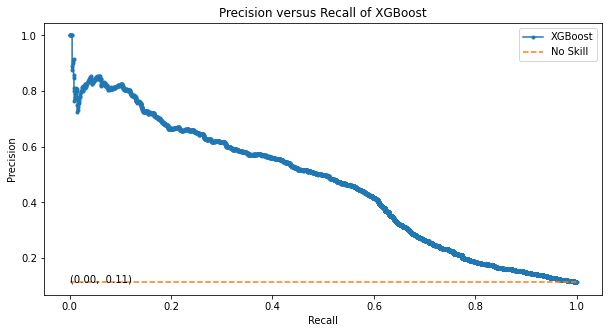

In [10]:
model_performance(xg_cl, kfolds = 10)

The performance of the XGBoost model is better than the random forest model but worse than the logistic regression model.

## Performance Summary for Baseline Algorithms

In [11]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
logreg_scores = [0.45, 0.46, 0.37]
rf_scores = [0.40, 0.42, 0.41]
XGBoost_scores = [0.44, 0.46, 0.41]
metrics = ['AUC_pr_10-fold_CV_train', 'AUC_pr_test', 'f1_minor_class_test']
performance_summary = [logreg_scores, rf_scores, XGBoost_scores]
base_algos = pd.DataFrame(performance_summary, index = models, columns = metrics)
base_algos

,AUC_pr_10-fold_CV_train,AUC_pr_test,f1_minor_class_test
Logistic Regression,0.45,0.46,0.37
Random Forest,0.40,0.42,0.41
XGBoost,0.44,0.46,0.41


We observe that the logistic regression model beats out the other models based on average precision scores but performs worse than the other models on the f1 score of the minority class. 

# Performance with Class Weights

As noted earlier, the ratio of the minority to majority class is 1:8. We will therefore assign a class weight of 8 to the minority class errors. This ensure that the misclassification of the minority class is penalized more than the misclassification of the majority class. 

## Logistic Regression

We will apply class weights to the logistic regression model and determine if this improves performance.

In [12]:
logreg_cw = LogisticRegression(class_weight = {0: 1, 1: 8}, max_iter = 10000, random_state = 77)
logreg_cw.__name__ = 'Logistic Regression with Class Weights'

Results for Logistic Regression with Class Weights 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.44 +/- 0.03
Area Under Precision-Recall Curve for Test Set              : 0.46
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     10965
           1       0.34      0.65      0.45      1392

    accuracy                           0.82     12357
   macro avg       0.65      0.75      0.67     12357
weighted avg       0.88      0.82      0.84     12357



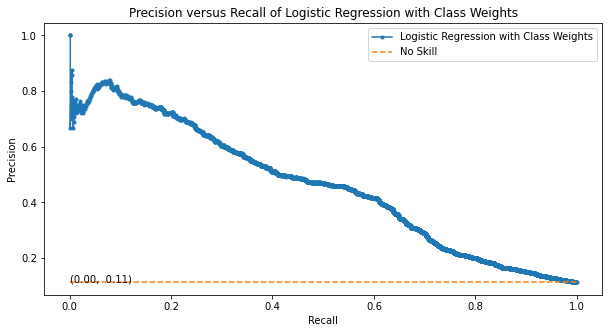

In [13]:
model_performance(logreg_cw, kfolds = 10)

The cross-validated mean Average Precision performance slightly reduced from 0.45 (logreg without class weights) to 0.44 (logreg with class weights). However, we saw substantial improvement in our f1 score (from 0.37 to 0.45). 

## Random Forest 

We will apply class weights to the random forest model and determine if this improves performance.

In [14]:
rf_cw = RandomForestClassifier(class_weight = {0: 1, 1: 8}, random_state = 77)
rf_cw.__name__ = 'Random Forest with Class Weights'

Results for Random Forest with Class Weights 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.40 +/- 0.03
Area Under Precision-Recall Curve for Test Set              : 0.41
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     10965
           1       0.55      0.30      0.39      1392

    accuracy                           0.89     12357
   macro avg       0.73      0.64      0.67     12357
weighted avg       0.88      0.89      0.88     12357



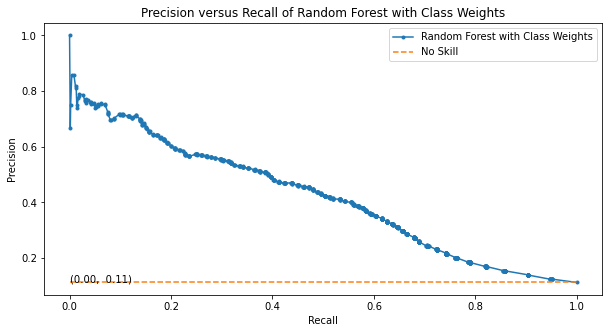

In [15]:
model_performance(rf_cw, kfolds = 10)

We note that including a class weight parameter does not improve the performance of the random forest classifier. They both resulted in a cross-validated mean average precision score of 0.4 and the f1 score is worse (0.39 versus 0.41).

## XGBoost

We will apply class weights to the XGBoost model and determine if this improves performance.

In [16]:
xg_cw = xgb.XGBClassifier(objective = 'binary:logistic', use_label_encoder = False, eval_metric = 'logloss', scale_pos_weight = 8, seed = 77)
xg_cw.__name__ = 'XGBoost With Class Weights'

Results for XGBoost With Class Weights 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.42 +/- 0.03
Area Under Precision-Recall Curve for Test Set              : 0.44
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.94      0.87      0.90     10965
           1       0.37      0.60      0.45      1392

    accuracy                           0.84     12357
   macro avg       0.66      0.73      0.68     12357
weighted avg       0.88      0.84      0.85     12357



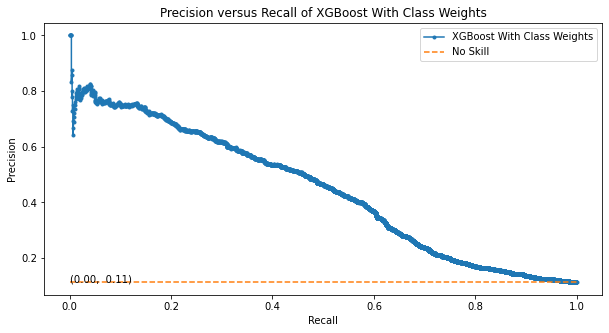

In [17]:
model_performance(xg_cw, kfolds = 10)

We note that including class weights reduces the performance of the XGBoost Classifier. The cross-validated mean Average Precision performance reduced from 0.44 (xgboost without class weights) to 0.42 (xgboost with class weights). However, the f1 score improved. 

## Performance Summary of Algorithms with Class Weights

In [18]:
models_cw = ['Logistic Regression with Class Weights', 'Random Forest with Class Weights', 'XGBoost with Class Weights']
logreg_cw_scores = [0.44, 0.46, 0.45]
rf_cw_scores = [0.40, 0.41, 0.39]
XGBoost_cw_scores = [0.42, 0.44, 0.45]
performance_summary_cw = [logreg_cw_scores, rf_cw_scores, XGBoost_cw_scores]
class_weights = pd.DataFrame(performance_summary_cw, index = models_cw, columns = metrics)
class_weights

,AUC_pr_10-fold_CV_train,AUC_pr_test,f1_minor_class_test
Logistic Regression with Class Weights,0.44,0.46,0.45
Random Forest with Class Weights,0.40,0.41,0.39
XGBoost with Class Weights,0.42,0.44,0.45


The model that seemed to benefit the most from applying class weights was the logistic regression model. Even though its cross validation average precision reduced by 0.01, its f1 score went up significantly.

# Undersampling and Oversampling

Another technique to deal with the imbalanced nature of our data is to resample the data in such a way that creates an equal number of observations for our target features - in this case, having the same number of clients that said 'yes' and 'no' to the marketing camapagne. The imbalanced nature of our dataset may result in models that are biased towards the majority class due to their comparatively higher numbers. Balancing the dataset may reduce this bias. We accomplish this by either reducing the number of clients in the majority class to equal that of the minority class or increasing the number of clients in the minority class to equal that of the majority class by resampling with replacement. We will try both approaches. We will balance only data in our training set. The test set (as usual) will be used to determine the performance of our balancing techniques.

## Random Undersampling

In this case, we will randomly select a number of clients in the majority class to equal that of the minority class. 

In [19]:
#Create scaled dataframe to undersample from 
df = pd.merge(pd.DataFrame(X_train, columns = features_coded), y_train, left_index = True, right_index = True)
df.head(2)

,age,currentCampaignContacts,daysLastContacted,previousCampaignContacts,employmentRate,cpi,cci,euribor3m,noEmployed,job_admin.,...,month_sep,dayOfWeek_fri,dayOfWeek_mon,dayOfWeek_thu,dayOfWeek_tue,dayOfWeek_wed,lastCampaignOutcome_failure,lastCampaignOutcome_nonexistent,lastCampaignOutcome_success,response
0,-0.386145,-0.204909,0.195414,-0.349494,-0.115781,-0.649003,-0.323542,0.328471,0.398115,-0.582023,...,-0.118462,-0.484371,1.959000,-0.514581,-0.494394,-0.496067,-0.33929,0.397706,-0.1857,0
1,1.916870,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.711307,0.331680,-0.582023,...,-0.118462,2.064533,-0.510465,-0.514581,-0.494394,-0.496067,-0.33929,0.397706,-0.1857,0


In [20]:
#Determine number of 'yes' responses as basis to undersample
df.response.value_counts()

0    19045
1     1134
Name: response, dtype: int64

In [21]:
# Shuffle data
df_shuffled = df.sample(frac=1)

# Create subsamples for 'yes' class, which is 1134 rows.
yes_df = df_shuffled.loc[df_shuffled.response == 1]
no_df = df_shuffled.loc[df_shuffled.response == 0][:1134]

normal_df = pd.concat([yes_df, no_df])

# Shuffle dataframe rows
df_undersampled = normal_df.sample(frac=1, random_state= 77)

df_undersampled.head()

,age,currentCampaignContacts,daysLastContacted,previousCampaignContacts,employmentRate,cpi,cci,euribor3m,noEmployed,job_admin.,...,month_sep,dayOfWeek_fri,dayOfWeek_mon,dayOfWeek_thu,dayOfWeek_tue,dayOfWeek_wed,lastCampaignOutcome_failure,lastCampaignOutcome_nonexistent,lastCampaignOutcome_success,response
26198,-0.674021,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.711883,0.331680,-0.582023,...,-0.118462,-0.484371,-0.510465,-0.514581,2.022677,-0.496067,-0.339290,0.397706,-0.1857,0
4872,0.477486,-0.565922,0.195414,-0.349494,-0.115781,-0.649003,-0.323542,0.328471,0.398115,-0.582023,...,-0.118462,-0.484371,1.959000,-0.514581,-0.494394,-0.496067,-0.339290,0.397706,-0.1857,1
28337,1.341116,0.156105,0.195414,-0.349494,-1.898153,-1.058448,-0.064259,-1.356812,-1.257233,1.718146,...,-0.118462,2.064533,-0.510465,-0.514581,-0.494394,-0.496067,-0.339290,0.397706,-0.1857,1
3551,-0.194227,-0.565922,0.195414,-0.349494,0.839061,0.591424,-0.474791,0.772999,0.845170,1.718146,...,-0.118462,-0.484371,-0.510465,-0.514581,2.022677,-0.496067,-0.339290,0.397706,-0.1857,0
13457,1.149199,-0.565922,0.195414,1.671136,-0.115781,-0.649003,-0.323542,0.230456,0.398115,-0.582023,...,-0.118462,2.064533,-0.510465,-0.514581,-0.494394,-0.496067,2.947327,-2.514421,-0.1857,1


In [22]:
#Check distribution of response
df_undersampled.response.value_counts()

0    1134
1    1134
Name: response, dtype: int64

In [23]:
#Create X_train and y_train for undersampled dataframe
X_train_undersampled = df_undersampled.drop(columns = ['response'])
y_train_undersampled = df_undersampled.response.values.ravel()

### Train Models on Undersampled Dataframe And Assess Performance

#### Logistic Regression 

In [24]:
logreg_undersampled = LogisticRegression(max_iter = 10000, random_state = 77)
logreg_undersampled.__name__ = 'Logistic Regression With Undersampling'

Results for Logistic Regression With Undersampling 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.51 +/- 0.03
Area Under Precision-Recall Curve for Test Set              : 0.13
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.89      0.52      0.66     10965
           1       0.12      0.51      0.19      1392

    accuracy                           0.52     12357
   macro avg       0.51      0.51      0.43     12357
weighted avg       0.81      0.52      0.61     12357



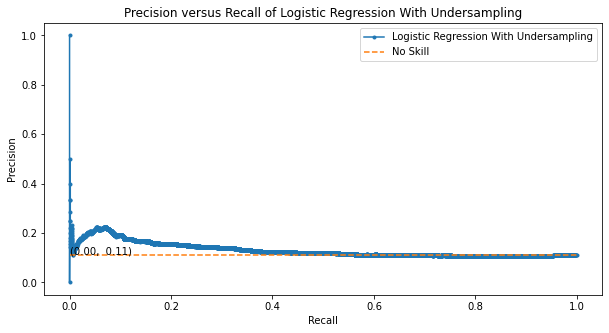

In [25]:
model_performance(logreg_undersampled, X_train_undersampled, y_train_undersampled, kfolds = 10)

Although our undersampling improved our test scores, it significantly reduced our test scores such that our average precision is barely better than the no-skill performance as illustrated in the chart.

#### Random Forest 

In [26]:
rf_undersampled = RandomForestClassifier(random_state = 77)
rf_undersampled.__name__ = 'Random Forest With Undersampling'

Results for Random Forest With Undersampling 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.52 +/- 0.02
Area Under Precision-Recall Curve for Test Set              : 0.11
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.89      0.52      0.65     10965
           1       0.11      0.48      0.18      1392

    accuracy                           0.51     12357
   macro avg       0.50      0.50      0.42     12357
weighted avg       0.80      0.51      0.60     12357



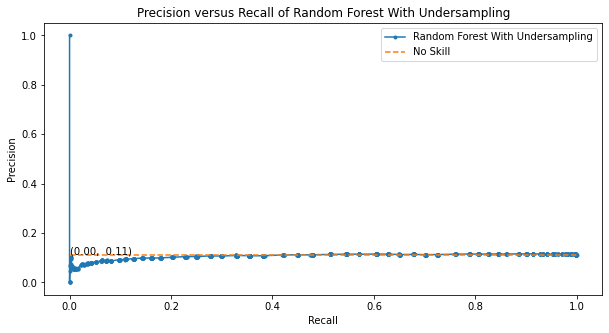

In [27]:
model_performance(rf_undersampled, X_train_undersampled, y_train_undersampled, kfolds = 10)

Similarly to our logistic regression model, our performance on the random forest model is poor on the test set. 

#### XGBoost

In [28]:
xg_undersampled = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder = False, eval_metric = 'logloss', seed= 77)
xg_undersampled.__name__ = 'XGBoost With Undersampling'

Results for XGBoost With Undersampling 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.52 +/- 0.04
Area Under Precision-Recall Curve for Test Set              : 0.13
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.89      0.50      0.64     10965
           1       0.11      0.50      0.19      1392

    accuracy                           0.50     12357
   macro avg       0.50      0.50      0.41     12357
weighted avg       0.80      0.50      0.59     12357



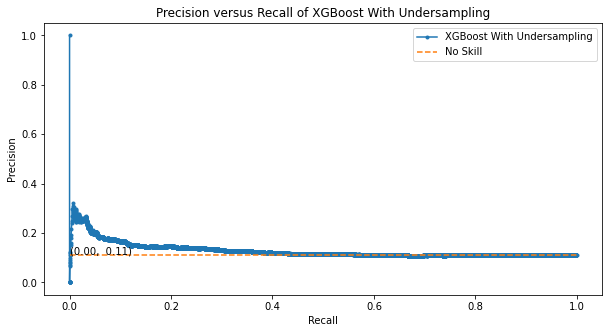

In [29]:
model_performance(xg_undersampled, X_train_undersampled, y_train_undersampled, kfolds = 10)

Similarly to our logistic regression and random forest models, our performance on the XGBoost model is poor on the test set. 

### Performance Summary of Random Undersampling

In [30]:
models_under = ['Logistic Regression with Undersampling', 'Random Forest with Undersampling', 'XGBoost with Undersampling']
logreg_under_scores = [0.53, 0.13, 0.19]
rf_under_scores = [0.52, 0.11, 0.18]
XGBoost_under_scores = [0.52, 0.14, 0.19]
performance_summary_under = [logreg_under_scores, rf_under_scores, XGBoost_under_scores]
undersampling = pd.DataFrame(performance_summary_under, index = models_under, columns = metrics)
undersampling

,AUC_pr_10-fold_CV_train,AUC_pr_test,f1_minor_class_test
Logistic Regression with Undersampling,0.53,0.13,0.19
Random Forest with Undersampling,0.52,0.11,0.18
XGBoost with Undersampling,0.52,0.14,0.19


The undersampled models performed well on the training set, but substantially worse on the test set. This implies that the models created by undersampled data is significantly different from those created by the more representative dataset.

## Random Oversampling

In this case, we will oversample the minority class to equal the number of clients in the majority class.

In [31]:
#Determine number of 'yes' and 'no' responses as basis to oversample
df.response.value_counts()

0    19045
1     1134
Name: response, dtype: int64

We need 19,045 samples of the 'yes' class.

In [32]:
# Shuffle data
df_shuffled_over = df.sample(frac=1)

# Create subsamples for 'yes' class, which is 1134 rows.
yes_df_over = df_shuffled_over.loc[df_shuffled_over.response == 1].sample(n = 19045, replace = True)
no_df_over = df_shuffled_over.loc[df_shuffled_over.response == 0]

normal_df_over = pd.concat([yes_df_over, no_df_over])

# Shuffle dataframe rows
df_oversampled = normal_df_over.sample(frac=1, random_state= 77)

df_oversampled.head()

,age,currentCampaignContacts,daysLastContacted,previousCampaignContacts,employmentRate,cpi,cci,euribor3m,noEmployed,job_admin.,...,month_sep,dayOfWeek_fri,dayOfWeek_mon,dayOfWeek_thu,dayOfWeek_tue,dayOfWeek_wed,lastCampaignOutcome_failure,lastCampaignOutcome_nonexistent,lastCampaignOutcome_success,response
17160,0.573445,1.600159,0.195414,-0.349494,-1.197935,-0.864955,-1.425496,-1.277824,-0.940281,1.718146,...,-0.118462,-0.484371,-0.510465,-0.514581,-0.494394,2.015858,-0.339290,0.397706,-0.1857,0
14573,0.669404,-0.565922,0.195414,1.671136,-0.115781,-0.649003,-0.323542,0.230456,0.398115,-0.582023,...,-0.118462,2.064533,-0.510465,-0.514581,-0.494394,-0.496067,2.947327,-2.514421,-0.1857,0
26705,0.189609,-0.204909,0.195414,-0.349494,0.648092,0.722722,0.886447,0.712460,0.331680,1.718146,...,-0.118462,-0.484371,-0.510465,-0.514581,2.022677,-0.496067,-0.339290,0.397706,-0.1857,0
2538,-0.769980,3.766239,0.195414,-0.349494,0.839061,0.591424,-0.474791,0.773575,0.845170,-0.582023,...,-0.118462,2.064533,-0.510465,-0.514581,-0.494394,-0.496067,-0.339290,0.397706,-0.1857,0
2584,-0.194227,-0.204909,0.195414,-0.349494,-1.197935,-1.179380,-1.231034,-1.357965,-0.940281,-0.582023,...,-0.118462,-0.484371,-0.510465,-0.514581,2.022677,-0.496067,-0.339290,0.397706,-0.1857,0


In [33]:
#Check distribution of response
df_oversampled.response.value_counts()

0    19045
1    19045
Name: response, dtype: int64

In [34]:
#Create X_train and y_train for undersampled dataframe
X_train_oversampled = df_oversampled.drop(columns = ['response'])
y_train_oversampled = df_oversampled.response.values.ravel()

### Train Models on Oversampled Dataframe And Assess Performance


#### Logistic Regression 

In [35]:
logreg_oversampled = LogisticRegression(max_iter = 10000, random_state = 77)
logreg_oversampled.__name__ = 'Logistic Regression With Oversampling'

Results for Logistic Regression With Oversampling 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.54 +/- 0.00
Area Under Precision-Recall Curve for Test Set              : 0.11
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.87      0.51      0.65     10965
           1       0.10      0.41      0.16      1392

    accuracy                           0.50     12357
   macro avg       0.49      0.46      0.40     12357
weighted avg       0.79      0.50      0.59     12357



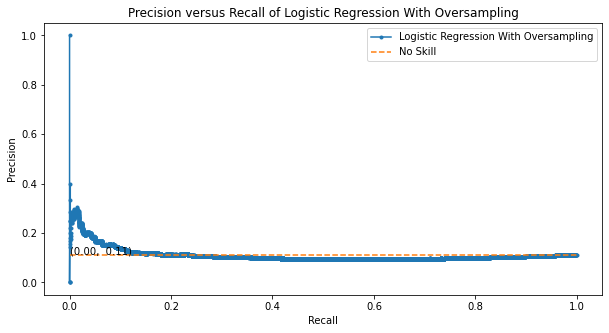

In [36]:
model_performance(logreg_oversampled, X_train_oversampled, y_train_oversampled, kfolds = 10)

Similar to the undersampling case, the logistc regression model performs well on the cross-validated training set but poorly on the test set.

#### Random Forest

In [37]:
rf_oversampled = RandomForestClassifier(random_state = 77)
rf_oversampled.__name__ = 'Random Forest With Oversampling'

Results for Random Forest With Oversampling 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 1.00 +/- 0.00
Area Under Precision-Recall Curve for Test Set              : 0.11
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.89      0.99      0.93     10965
           1       0.07      0.01      0.02      1392

    accuracy                           0.88     12357
   macro avg       0.48      0.50      0.47     12357
weighted avg       0.79      0.88      0.83     12357



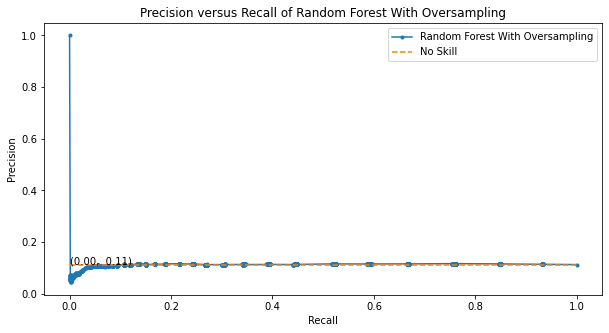

In [38]:
model_performance(rf_oversampled, X_train_oversampled, y_train_oversampled, kfolds = 10)

Our random forest model performs perfectly on the cross-validated training set but very poorly on the test set.

#### XGBoost

In [39]:
xg_oversampled = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder = False, eval_metric = 'logloss', seed= 77)
xg_oversampled.__name__ = 'XGBoost With Oversampling'

Results for XGBoost With Oversampling 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.94 +/- 0.00
Area Under Precision-Recall Curve for Test Set              : 0.08
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.88      0.81      0.84     10965
           1       0.07      0.11      0.08      1392

    accuracy                           0.73     12357
   macro avg       0.47      0.46      0.46     12357
weighted avg       0.79      0.73      0.76     12357



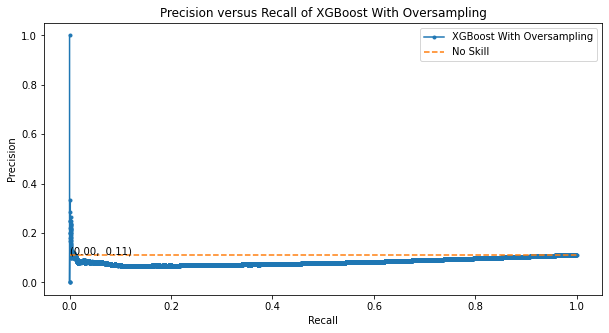

In [40]:
model_performance(xg_oversampled, X_train_oversampled, y_train_oversampled, kfolds = 10)

Our XGBoost model performs remarkably well on the training set but very poorly on the test set. 

### Performance Summary for Random Oversampling

In [67]:
models_over = ['Logistic Regression with Oversampling', 'Random Forest with Oversampling', 'XGBoost with Oversampling']
logreg_over_scores = [0.54, 0.12, 0.16]
rf_over_scores = [1.00, 0.11, 0.02]
XGBoost_over_scores = [0.94, 0.09, 0.09]
performance_summary_over = [logreg_over_scores, rf_over_scores, XGBoost_over_scores]
oversampling_df = pd.DataFrame(performance_summary_over, index = models_over, columns = metrics)
oversampling_df

,AUC_pr_10-fold_CV_train,AUC_pr_test,f1_minor_class_test
Logistic Regression with Oversampling,0.54,0.12,0.16
Random Forest with Oversampling,1.00,0.11,0.02
XGBoost with Oversampling,0.94,0.09,0.09


We observe that we get even higher average precision scores on the cross-validated training set when we oversample. However, our test scores are still poor.

## Oversampling with SMOTE (Synthetic Minority Oversampling Technique)

SMOTE oversamples the minority class by interpolating between nearest neigbhours associated with minority examples. This is a more suffisticated way of oversampling the dataset rather than resampling with replacement. We will determine if SMOTE provides improved performance scores on our base algorithms.

### Creating SMOTE Dataset

In [42]:
oversampling = SMOTE()
X_SMOTE, y_SMOTE = oversampling.fit_resample(X_train, y_train)

In [43]:
#Data is balanced
y_SMOTE.value_counts()

0    25583
1    25583
Name: response, dtype: int64

### Train Models on SMOTE Dataframe And Assess Performance


#### Logistic Regression

In [44]:
logreg_SMOTE = LogisticRegression(max_iter = 10000, random_state = 77)
logreg_SMOTE.__name__ = 'Logistic Regression With SMOTE'

Results for Logistic Regression With SMOTE 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.82 +/- 0.01
Area Under Precision-Recall Curve for Test Set              : 0.46
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     10965
           1       0.33      0.66      0.44      1392

    accuracy                           0.81     12357
   macro avg       0.64      0.74      0.66     12357
weighted avg       0.88      0.81      0.84     12357



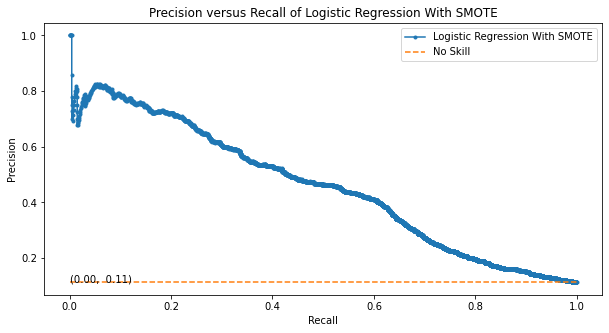

In [45]:
model_performance(logreg_SMOTE, X_SMOTE, y_SMOTE, kfolds = 10)

The cross-validated score is high for the SMOTE dataset and we get good performance scores on our test set as well. Our test f1 score for the logistic regression algorithm with class weights is however better (0.45 versus 0.44).

#### Random Forest

In [46]:
rf_SMOTE = RandomForestClassifier(random_state = 77)
rf_SMOTE.__name__ = 'Random Forest With SMOTE'

Results for Random Forest With SMOTE 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.99 +/- 0.03
Area Under Precision-Recall Curve for Test Set              : 0.40
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     10965
           1       0.50      0.38      0.43      1392

    accuracy                           0.89     12357
   macro avg       0.71      0.67      0.68     12357
weighted avg       0.88      0.89      0.88     12357



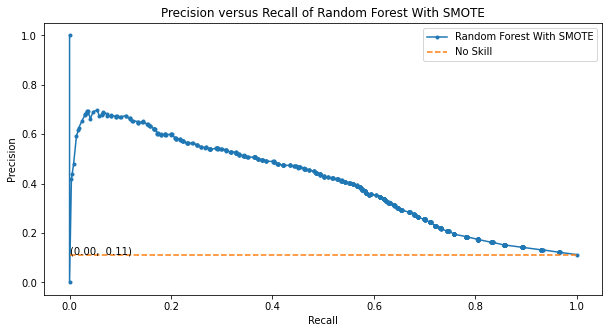

In [47]:
model_performance(rf_SMOTE, X_SMOTE, y_SMOTE, kfolds = 10)

Again, we observe high average precision scores for the cross-validated train set. The test scores are mixed. SMOTE oversampling improves the f1 score when compared to the base dataset (0.43 versus 0.42) but reduces the average precision score when compared to the base dataset (0.4 versus 0.42). These differences are however not significant. 

#### XGBoost

In [48]:
xg_SMOTE = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder = False, eval_metric = 'logloss', seed= 77)
xg_SMOTE.__name__ = 'XGBoost With SMOTE'

Results for XGBoost With SMOTE 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.98 +/- 0.05
Area Under Precision-Recall Curve for Test Set              : 0.46
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     10965
           1       0.59      0.33      0.42      1392

    accuracy                           0.90     12357
   macro avg       0.76      0.65      0.68     12357
weighted avg       0.88      0.90      0.89     12357



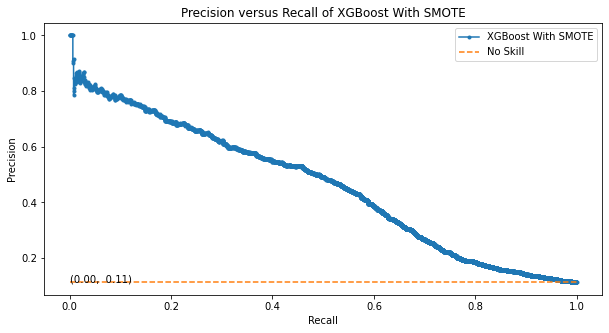

In [49]:
model_performance(xg_SMOTE, X_SMOTE, y_SMOTE, kfolds = 10)

SMOTE oversampling improves the cross-validated average precision score on the training set, but not much else. The f1 score and averaga precision score on the test set is worse when  compared to the base XGBoost model. 

### Performance Summary for SMOTE

In [50]:
models_SMOTE = ['Logistic Regression with SMOTE', 'Random Forest with SMOTE', 'XGBoost with SMOTE']
logreg_SMOTE_scores = [0.82, 0.46, 0.44]
rf_SMOTE_scores = [0.99, 0.40, 0.43]
XGBoost_SMOTE_scores = [0.98, 0.46, 0.40]
performance_summary_SMOTE = [logreg_SMOTE_scores, rf_SMOTE_scores, XGBoost_SMOTE_scores]
SMOTE_df = pd.DataFrame(performance_summary_SMOTE, index = models_SMOTE, columns = metrics)
SMOTE_df

,AUC_pr_10-fold_CV_train,AUC_pr_test,f1_minor_class_test
Logistic Regression with SMOTE,0.82,0.46,0.44
Random Forest with SMOTE,0.99,0.40,0.43
XGBoost with SMOTE,0.98,0.46,0.40


SMOTE definitely produced scores that were much better than random oversampling, but these results were not significantly better than scores obtained on the base models for the test set.

## SMOTE with Undersampling

In addition to synthetic oversampling of the minority class one could also undersample the majority. This may lead to better scores.We shall create a new dataset with this approach and determine the performance of our models.

### Create SMOTE with Undersampling Dataset

We will oversample the minority samples to be 50% of the majority samples and undersample the majority samples to be 50% of the majority samples.

In [51]:
#Create SMOTE oversampling of minority class and undersampling of majority class
oversampler = SMOTE(sampling_strategy = 0.5)
undersampler = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('oversampler', oversampler), ('undersampler', undersampler)]
pipeline = Pipeline(steps = steps)

In [52]:
#Create SMOTE dataset that has been undersampled
X_SMOTE_under, y_SMOTE_under = pipeline.fit_resample(X_train, y_train)

In [53]:
#Review class distribution
y_SMOTE_under.value_counts()

0    25582
1    12791
Name: response, dtype: int64

### Train Models on undersampled SMOTE Dataframe And Assess Performance


#### Logistic Regression

In [54]:
logreg_SMOTE_under = LogisticRegression(max_iter = 10000, random_state = 77)
logreg_SMOTE_under.__name__ = 'Logistic Regression With SMOTE and Undersampling'

Results for Logistic Regression With SMOTE and Undersampling 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.71 +/- 0.01
Area Under Precision-Recall Curve for Test Set              : 0.46
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     10965
           1       0.44      0.55      0.49      1392

    accuracy                           0.87     12357
   macro avg       0.69      0.73      0.71     12357
weighted avg       0.88      0.87      0.88     12357



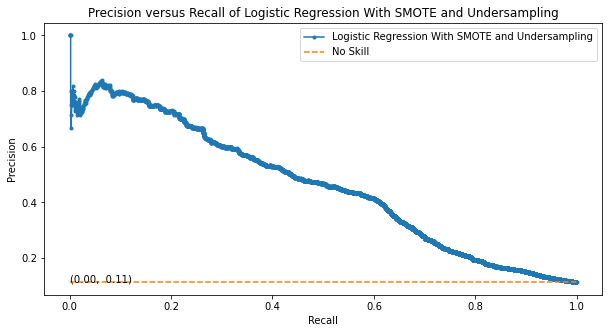

In [55]:
model_performance(logreg_SMOTE_under, X_SMOTE_under, y_SMOTE_under, kfolds = 10)

Here again, we notice performance on the test set is not significantly better than the base logistic regression model.

#### Random Forest

In [56]:
rf_SMOTE_under = RandomForestClassifier(random_state = 77)
rf_SMOTE_under.__name__ = 'Random Forest With SMOTE and Undersampling'

Results for Random Forest With SMOTE and Undersampling 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.94 +/- 0.09
Area Under Precision-Recall Curve for Test Set              : 0.41
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10965
           1       0.52      0.36      0.42      1392

    accuracy                           0.89     12357
   macro avg       0.72      0.66      0.68     12357
weighted avg       0.88      0.89      0.88     12357



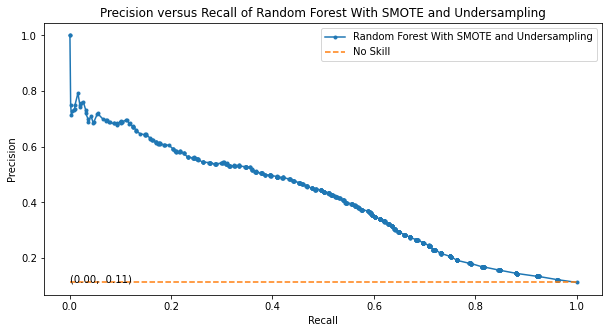

In [57]:
model_performance(rf_SMOTE_under, X_SMOTE_under, y_SMOTE_under, kfolds = 10)

We notice that the performance on the test set is not significantly better than the base random forest model.

#### XGBoost

In [58]:
xg_SMOTE_under = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder = False, eval_metric = 'logloss', seed= 77)
xg_SMOTE_under.__name__ = 'XGBoost With Oversampling and Undersampling'

Results for XGBoost With Oversampling and Undersampling 
Area Under Precision-Recall Curve for Train Set (10-fold CV): 0.93 +/- 0.11
Area Under Precision-Recall Curve for Test Set              : 0.46
Area Under P-R Curve on Test Set (No-Skill Performance)     : 0.11
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     10965
           1       0.60      0.31      0.41      1392

    accuracy                           0.90     12357
   macro avg       0.76      0.64      0.68     12357
weighted avg       0.88      0.90      0.88     12357



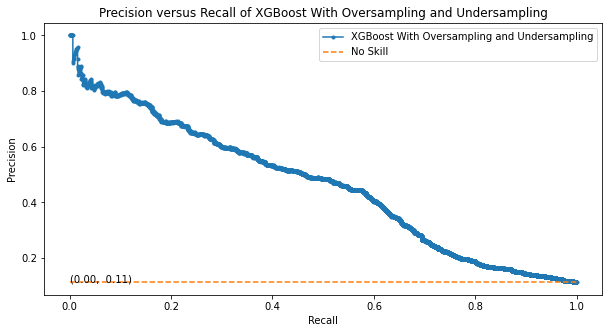

In [59]:
model_performance(xg_SMOTE_under, X_SMOTE_under, y_SMOTE_under, kfolds = 10)

Here again, we notice performance on the test set is not significantly better than the base XGBoost model.

### Performance Summary for Undersampled SMOTE

In [60]:
models_SMOTE_under = ['Logistic Regression with undersampled SMOTE', 'Random Forest with undersampled SMOTE', 'XGBoost with undersampled SMOTE']
logreg_SMOTE_under_scores = [0.82, 0.46, 0.44]
rf_SMOTE_under_scores = [0.99, 0.40, 0.43]
XGBoost_SMOTE_under_scores = [0.98, 0.46, 0.40]
performance_summary_SMOTE_under = [logreg_SMOTE_under_scores, rf_SMOTE_under_scores, XGBoost_SMOTE_under_scores]
SMOTE_under = pd.DataFrame(performance_summary_SMOTE_under, index = models_SMOTE_under, columns = metrics)
SMOTE_under

,AUC_pr_10-fold_CV_train,AUC_pr_test,f1_minor_class_test
Logistic Regression with undersampled SMOTE,0.82,0.46,0.44
Random Forest with undersampled SMOTE,0.99,0.40,0.43
XGBoost with undersampled SMOTE,0.98,0.46,0.40


SMOTE with undersampling does not improve the performance of the models.

# Conclusion

In [68]:
#Get model performance scores for all models
pd.concat([base_algos, class_weights, undersampling, SMOTE_df, oversampling_df, SMOTE_under]).sort_values(by = ['AUC_pr_test', 'f1_minor_class_test'], ascending = False)

,AUC_pr_10-fold_CV_train,AUC_pr_test,f1_minor_class_test
Logistic Regression with Class Weights,0.44,0.46,0.45
Logistic Regression with SMOTE,0.82,0.46,0.44
Logistic Regression with undersampled SMOTE,0.82,0.46,0.44
XGBoost,0.44,0.46,0.41
XGBoost with SMOTE,0.98,0.46,0.40
XGBoost with undersampled SMOTE,0.98,0.46,0.40
Logistic Regression,0.45,0.46,0.37
XGBoost with Class Weights,0.42,0.44,0.45
Random Forest,0.40,0.42,0.41
Random Forest with Class Weights,0.40,0.41,0.39


The goal of our project was to create a model to predict the response of a marketing campagne, whether a 'yes' or 'no'. To do so, we created various imperfect models that improved our ability to predict the response. We highlighted the importance of prioritizing the prediction of our positive class because these were clients, especially because of the imbalanced nature of the dataset, with a 1:8 ratio of clients who responded positively to the marketing campagne and those who did not. Accordingly, we determined that precision and recall were the most useful metrics of relevance and the area under the precision-recall curve as the most important scoring metric followed by the f1 score. 

From the above models, the logisitic regression model with class weights offered the best performance on the test set, both in terms of the average precision and the f1 score for the minority class. This is the model we recommend to the business.

Generally, the logisitic regression algorithm performed better than the random forest and XGBoost algorithm. We also noted that random undersampling and oversampling techniques yielded poor results.

# Further Improvements

The business should consider the following measures to improve the performance of the model.

1. Gather more data as they continue their campagne
2. Review other algorithms to determine if they improve performance
3. Engineer additional features